## PHASE 1 : BUSINESS UNDERSTANDING

# Problem statement

Identify which foods and lifecycle stages (farm, processing, transport, etc.) drive the largest environmental burdens, and recommend the highest-leverage actions (dietary swaps, sourcing policies, logistics/packaging changes) to lower total impact without undermining nutrition or cost.


# Stakeholders & decisions

- Policy & NGOs: dietary guidance, incentives for lower-impact foods, water-scarcity risk management. 

- Procurement & Retail: product mix, supplier selection, transport/packaging optimization.

- Producers/Farmers: practice changes (feed, fertilizer, irrigation efficiency).

- Consumers: informed swaps toward lower-impact alternatives.

# Success metrics (KPIs)

- GHG intensity (kg CO₂-eq per kg product; and optionally per 1000 kcal / per 100 g protein for fair comparisons across food types).

- Water footprint (freshwater withdrawals; scarcity-weighted water use).

- Land use & land-use change contributions.

- Stage contributions (% share from farm/feed/processing/transport/packaging/retail).


# Business Questions
These are the key business questions to be answered by the end of the project:

1. Which foods are highest/lowest impact by GHG per kg? By kcal? By 100 g protein? 

2. Which lifecycle stages dominate impacts for each food (e.g., farm vs transport vs packaging)? 


3. Top leverage points: which 8–10 foods account for ~80% of total GHG (Pareto) and what stage drives each?

4. Water risk: which foods have extreme scarcity-weighted water use, and where do withdrawals cluster?

5. Dietary swaps: what realistic substitutions (e.g., beef → poultry/legumes; dairy → plant milks) yield the largest impact reduction per serving of protein/kcal?

6. Transport & packaging sensitivity: for which foods are these stages non-trivial (i.e., >10–15%)?

7. Consistency trade-offs: do lower-GHG foods sometimes have higher water or land footprints? What’s the recommended balance?

8. Scenario impact: if a retailer shifts X% of sales from high- to medium-impact foods, what is the projected GHG/water reduction?

# PHASE 2: DATA UNDERSTANDING
The objective of this phase is to load the dataset, understand its structure, and perform initial exploration.

A. Loading and Inspecting the data

In [ ]:
# =========================
# 0) Imports & Config
# =========================
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

DATA_PATH = Path("Food_Production.csv")  


In [2]:

# 2) Load data & quick integrity checks

df = pd.read_csv(DATA_PATH)
rows, cols = df.shape

# Try to identify the label (food name) column
label_candidates_exact = { "food", "food product", "product", "item", "entity", "name" }
label_candidates = [c for c in df.columns if c.strip().lower() in label_candidates_exact]
if not label_candidates:
    # Fallback to the first object column; as a last resort, the first column
    obj_cols = df.select_dtypes(include="object").columns.tolist()
    LABEL = obj_cols[0] if obj_cols else df.columns[0]
else:
    LABEL = label_candidates[0]

print(f"Shape: {rows} rows × {cols} columns")
print(f"Label column: {LABEL!r}")
display(df.head(10))


Shape: 43 rows × 23 columns
Label column: 'Food product'


,Food product,Land use change,Animal Feed,Farm,Processing,Transport,Packging,Retail,Total_emissions,Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal),Eutrophying emissions per kilogram (gPO₄eq per kilogram),Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein),Freshwater withdrawals per 1000kcal (liters per 1000kcal),Freshwater withdrawals per 100g protein (liters per 100g protein),Freshwater withdrawals per kilogram (liters per kilogram),Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal),Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein),Land use per 1000kcal (m² per 1000kcal),Land use per kilogram (m² per kilogram),Land use per 100g protein (m² per 100g protein),Scarcity-weighted water use per kilogram (liters per kilogram),Scarcity-weighted water use per 100g protein (liters per 100g protein),Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)
0,Wheat & Rye (Bread),0.1,0.0,0.8,0.2,0.1,0.1,0.1,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Maize (Meal),0.3,0.0,0.5,0.1,0.1,0.1,0.0,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Barley (Beer),0.0,0.0,0.2,0.1,0.0,0.5,0.3,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oatmeal,0.0,0.0,1.4,0.0,0.1,0.1,0.0,1.6,4.281357,11.23,8.638462,183.911552,371.076923,482.4,0.945482,1.907692,2.897446,7.60,5.846154,18786.2,14450.92308,7162.104461
4,Rice,0.0,0.0,3.6,0.1,0.1,0.1,0.1,4.0,9.514379,35.07,49.394366,609.983722,3166.760563,2248.4,1.207271,6.267606,0.759631,2.80,3.943662,49576.3,69825.77465,13449.891480
5,Potatoes,0.0,0.0,0.2,0.0,0.1,0.0,0.0,0.3,4.754098,3.48,20.470588,80.737705,347.647059,59.1,0.628415,2.705882,1.202186,0.88,5.176471,2754.2,16201.17647,3762.568306
6,Cassava,0.6,0.0,0.2,0.0,0.1,0.0,0.0,0.9,0.708419,0.69,7.666667,NaN,NaN,0.0,1.355236,14.666667,1.858316,1.81,20.111111,0.0,NaN,NaN
7,Cane Sugar,1.2,0.0,0.5,0.0,0.8,0.1,0.0,2.6,4.820513,16.92,NaN,176.666667,NaN,620.1,0.911681,NaN,0.581197,2.04,NaN,16438.6,NaN,4683.361823
8,Beet Sugar,0.0,0.0,0.5,0.2,0.6,0.1,0.0,1.4,1.541311,5.41,NaN,62.022792,NaN,217.7,0.515670,NaN,0.521368,1.83,NaN,9493.3,NaN,2704.643875
9,Other Pulses,0.0,0.0,1.1,0.0,0.1,0.4,0.0,1.6,5.008798,17.08,7.977581,NaN,203.503036,435.7,0.524927,0.836058,4.565982,15.57,7.272303,22477.4,10498.55208,NaN


In [4]:

# 3) Checking Dtypes, missing rows, and duplicates

dtypes = df.dtypes.rename("dtype").to_frame()
missing = df.isna().sum().to_frame("missing_count")
missing["missing_pct"] = (missing["missing_count"] / len(df) * 100).round(2)
duplicate_rows = df.duplicated().sum()

display(dtypes.reset_index(names=["column"]))
display(missing.reset_index(names=["column"]).sort_values("missing_count", ascending=False))
print(f"Duplicate rows: {duplicate_rows}")


,column,dtype
0,Food product,object
1,Land use change,float64
2,Animal Feed,float64
3,Farm,float64
4,Processing,float64
5,Transport,float64
6,Packging,float64
7,Retail,float64
8,Total_emissions,float64
9,Eutrophying emissions per 1000kcal (gPO₄eq per...,float64


,column,missing_count,missing_pct
13,Freshwater withdrawals per 100g protein (liter...,17,39.53
21,Scarcity-weighted water use per 100g protein (...,17,39.53
16,Greenhouse gas emissions per 100g protein (kgC...,16,37.21
11,Eutrophying emissions per 100g protein (gPO₄eq...,16,37.21
19,Land use per 100g protein (m² per 100g protein),16,37.21
22,Scarcity-weighted water use per 1000kcal (lite...,13,30.23
12,Freshwater withdrawals per 1000kcal (liters pe...,13,30.23
15,Greenhouse gas emissions per 1000kcal (kgCO₂eq...,10,23.26
17,Land use per 1000kcal (m² per 1000kcal),10,23.26
9,Eutrophying emissions per 1000kcal (gPO₄eq per...,10,23.26


Duplicate rows: 0


In [5]:

# 4) Numeric audit: negatives, zeros, ranges

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

neg_counts = df[num_cols].lt(0).sum().sort_values(ascending=False)
zero_counts = df[num_cols].eq(0).sum().sort_values(ascending=False)

range_summary = pd.DataFrame({
    "min": df[num_cols].min(),
    "max": df[num_cols].max(),
    "mean": df[num_cols].mean()
}).sort_values("max", ascending=False)

display(neg_counts.to_frame("negative_count"))
display(zero_counts.to_frame("zero_count"))
display(range_summary)


,negative_count
Land use change,4
Animal Feed,0
Farm,0
Processing,0
Transport,0
Packging,0
Retail,0
Total_emissions,0
Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal),0
Eutrophying emissions per kilogram (gPO₄eq per kilogram),0


,zero_count
Animal Feed,33
Retail,29
Processing,18
Land use change,14
Packging,10
Transport,1
Scarcity-weighted water use per kilogram (liters per kilogram),1
Freshwater withdrawals per kilogram (liters per kilogram),1
Farm,0
Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal),0


,min,max,mean
Scarcity-weighted water use per 100g protein (liters per 100g protein),421.250000,431620.000000,59196.438503
Scarcity-weighted water use per kilogram (liters per kilogram),0.000000,229889.800000,36607.428947
Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories),4.095023,49735.882350,17380.575408
Freshwater withdrawals per 100g protein (liters per 100g protein),32.375000,6003.333333,1437.975324
Freshwater withdrawals per kilogram (liters per kilogram),0.000000,5605.200000,932.605263
Freshwater withdrawals per 1000kcal (liters per 1000kcal),0.723982,2062.178771,504.188977
Land use per kilogram (m² per kilogram),0.330000,369.810000,29.264474
Eutrophying emissions per kilogram (gPO₄eq per kilogram),0.690000,365.290000,46.141316
Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal),0.708419,197.357143,27.181547
Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein),3.384338,185.050659,52.771953


In [6]:

# 5) Column detection helpers (GHG stages & basis-aware metrics)

def normalize_name(s: str) -> str:
    """Conservatively slugify a column name while keeping useful tokens/units."""
    s = re.sub(r"\s+", "_", s.strip())
    s = re.sub(r"[^\w\-/·²³()]+", "_", s)   # retain simple units like CO2, m2, etc.
    return s.lower().strip("_")

def detect_columns(columns):
    """
    Heuristics to find:
    - total GHG columns (per kg / per 1000 kcal / per 100 g protein)
    - stage columns (land use change, animal feed, farm, processing, transport, packaging, retail)
    - water columns (freshwater withdrawals, scarcity-weighted water)
    """
    cols = list(columns)
    low = [c.lower() for c in cols]

    # Total GHG by basis
    total_perkg = [c for c in cols if re.search(r"(total|overall).*(co2|co₂|ghg).*?(per\s*kg|\b/kg\b)", c, re.I)]
    if not total_perkg:
        # Some datasets name it like "GHG emissions per kilogram" or similar
        total_perkg = [c for c in cols if re.search(r"(ghg|emission|co2|co₂).*(per\s*kg|\b/kg\b)", c, re.I) and "1000" not in c and "100 g" not in c.lower()]
    total_perkcal = [c for c in cols if re.search(r"(ghg|emission|co2|co₂).*(1000\s*kcal)", c, re.I)]
    total_perprotein = [c for c in cols if re.search(r"(ghg|emission|co2|co₂).*(100\s*g.*protein)", c, re.I)]

    # Stage columns (flexible matching)
    stage_patterns = {
        "land_use_change": r"land\s*use\s*change",
        "animal_feed": r"animal\s*feed",
        "farm": r"\bfarm\b",
        "processing": r"processing",
        "transport": r"transport",
        "packaging": r"packaging",
        "retail": r"retail",
    }
    stage_cols = {}
    for k, pat in stage_patterns.items():
        match = [c for c in cols if re.search(pat, c, re.I) and re.search(r"(co2|co₂|ghg|emission)", c, re.I)]
        stage_cols[k] = match[0] if match else None

    # Water metrics
    freshwater_cols = [c for c in cols if re.search(r"freshwater\s*withdrawals", c, re.I)]
    scarcity_cols   = [c for c in cols if re.search(r"scarcity[-\s]*weighted\s*water\s*use", c, re.I)]

    return {
        "total_ghg_perkg": total_perkg[:1],
        "total_ghg_per1000kcal": total_perkcal[:1],
        "total_ghg_per100g_protein": total_perprotein[:1],
        "stage_cols": stage_cols,
        "freshwater_cols": freshwater_cols,
        "scarcity_weighted_cols": scarcity_cols
    }

detected = detect_columns(df.columns)
detected


{'total_ghg_perkg': [],
 'total_ghg_per1000kcal': ['Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal)'],
 'total_ghg_per100g_protein': ['Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein)'],
 'stage_cols': {'land_use_change': None,
  'animal_feed': None,
  'farm': None,
  'processing': None,
  'transport': None,
  'packaging': None,
  'retail': None},
 'freshwater_cols': ['Freshwater withdrawals per 1000kcal (liters per 1000kcal)',
  'Freshwater withdrawals per 100g protein (liters per 100g protein)',
  'Freshwater withdrawals per kilogram (liters per kilogram)'],
 'scarcity_weighted_cols': ['Scarcity-weighted water use per kilogram (liters per kilogram)',
  'Scarcity-weighted water use per 100g protein (liters per 100g protein)',
  'Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)']}

In [7]:

# 6) Optional: standardize column names (safe copy)
df_clean = df.copy()
rename_map = {c: normalize_name(c) for c in df.columns}
df_clean.rename(columns=rename_map, inplace=True)

LABEL_CLEAN = rename_map[LABEL]
detected_clean = detect_columns(df_clean.columns)
detected_clean


{'total_ghg_perkg': [],
 'total_ghg_per1000kcal': ['eutrophying_emissions_per_1000kcal_(gpo₄eq_per_1000kcal)'],
 'total_ghg_per100g_protein': ['eutrophying_emissions_per_100g_protein_(gpo₄eq_per_100_grams_protein)'],
 'stage_cols': {'land_use_change': None,
  'animal_feed': None,
  'farm': None,
  'processing': None,
  'transport': None,
  'packaging': None,
  'retail': None},
 'freshwater_cols': [],
 'scarcity_weighted_cols': []}

In [8]:

# 7) Build total GHG per kg and stage shares (if possible)

def compute_total_ghg_perkg(df_in, detected_dict, label_col):
    df_out = df_in.copy()
    # Prefer reported total if present; otherwise sum stages if available
    total_col = detected_dict["total_ghg_perkg"][0] if detected_dict["total_ghg_perkg"] else None

    if total_col and total_col in df_out.columns:
        df_out["ghg_total_perkg"] = pd.to_numeric(df_out[total_col], errors="coerce")
        source = f"reported total: {total_col}"
    else:
        # Sum any available stage columns (only those found)
        stage_cols_found = [c for c in detected_dict["stage_cols"].values() if c is not None]
        if stage_cols_found:
            for c in stage_cols_found:
                df_out[c] = pd.to_numeric(df_out[c], errors="coerce")
            df_out["ghg_total_perkg"] = df_out[stage_cols_found].sum(axis=1)
            source = f"sum of stages: {stage_cols_found}"
        else:
            df_out["ghg_total_perkg"] = np.nan
            source = "not available"

    return df_out, source

df_clean, total_source = compute_total_ghg_perkg(df_clean, detected_clean, LABEL_CLEAN)
print("Total GHG per kg source:", total_source)
display(df_clean[[LABEL_CLEAN, "ghg_total_perkg"]].head())


Total GHG per kg source: not available


,food_product,ghg_total_perkg
0,Wheat & Rye (Bread),NaN
1,Maize (Meal),NaN
2,Barley (Beer),NaN
3,Oatmeal,NaN
4,Rice,NaN


In [9]:

# 9) Stage shares (if stages exist)

stage_cols_found = [c for c in detected_clean["stage_cols"].values() if c is not None]

if stage_cols_found:
    # ensure numeric
    for c in stage_cols_found:
        df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")
    # Avoid /0 divisions
    denom = df_clean["ghg_total_perkg"].replace({0: np.nan})
    for c in stage_cols_found:
        share_col = f"{normalize_name(c)}_share"
        df_clean[share_col] = df_clean[c] / denom

    share_cols = [c for c in df_clean.columns if c.endswith("_share")]
    display(df_clean[[LABEL_CLEAN, "ghg_total_perkg", *share_cols]].head())
else:
    print("No stage columns detected; skipping stage-share computation.")


No stage columns detected; skipping stage-share computation.


In [10]:

# 10) Water metrics (freshwater withdrawals & scarcity-weighted)

freshwater_cols = detected_clean["freshwater_cols"]
scarcity_cols    = detected_clean["scarcity_weighted_cols"]

def summarize_metric(df_in, label_col, cols, title):
    cols = [c for c in cols if c in df_in.columns]
    if not cols:
        print(f"{title}: not found.")
        return None
    # Display each column's top 8
    tables = {}
    for c in cols:
        df_in[c] = pd.to_numeric(df_in[c], errors="coerce")
        tables[c] = topn_table(df_in, label_col, c, n=8, title=f"Top 8 by {c}")
    return tables

freshwater_tables = summarize_metric(df_clean, LABEL_CLEAN, freshwater_cols, "Freshwater withdrawals")
scarcity_tables   = summarize_metric(df_clean, LABEL_CLEAN, scarcity_cols, "Scarcity-weighted water use")


Freshwater withdrawals: not found.
Scarcity-weighted water use: not found.


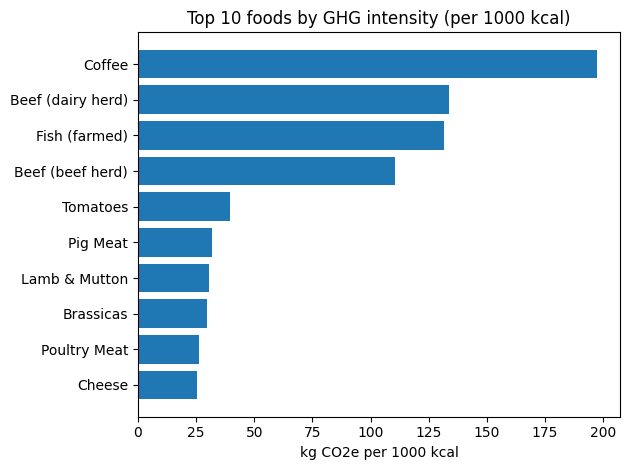

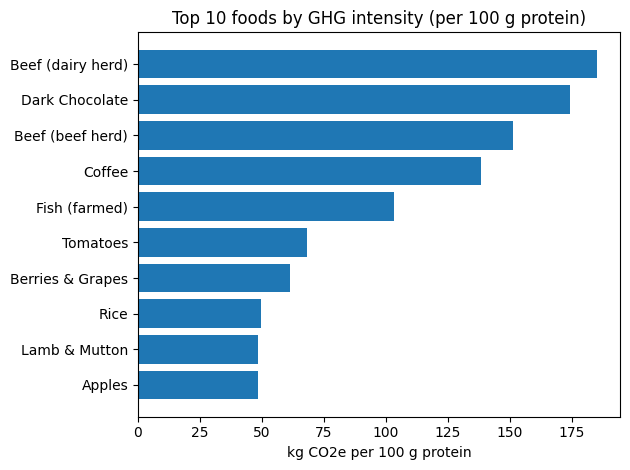

In [12]:
# --- Patch for NameError: define perkcal_col/perprot_col and safe fallbacks ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

def normalize_name(s: str) -> str:
    s = re.sub(r"\s+", "_", s.strip())
    s = re.sub(r"[^\w\-/·²³()]+", "_", s)
    return s.lower().strip("_")

def detect_columns(columns):
    cols = list(columns)
    # Totals by basis
    total_perkg = [c for c in cols if re.search(r"(total|overall).*(co2|co₂|ghg).*(/|\s)kg", c, re.I)]
    if not total_perkg:
        total_perkg = [c for c in cols if re.search(r"(ghg|emission|co2|co₂).*(/|\s)kg", c, re.I) and "1000" not in c and "100 g" not in c.lower()]
    total_perkcal = [c for c in cols if re.search(r"(ghg|emission|co2|co₂).*1000\s*kcal", c, re.I)]
    total_perprotein = [c for c in cols if re.search(r"(ghg|emission|co2|co₂).*100\s*g.*protein", c, re.I)]
    return {
        "total_ghg_perkg": total_perkg[:1],
        "total_ghg_per1000kcal": total_perkcal[:1],
        "total_ghg_per100g_protein": total_perprotein[:1],
    }

# Ensure df_clean exists; if not, fall back to df
if "df_clean" not in globals():
    if "df" in globals():
        df_clean = df.copy()
        df_clean.rename(columns={c: normalize_name(c) for c in df_clean.columns}, inplace=True)
    else:
        df_clean = pd.read_csv("Food_Production.csv")
        df_clean.rename(columns={c: normalize_name(c) for c in df_clean.columns}, inplace=True)

# Label fallback
if "LABEL_CLEAN" not in globals():
    obj_cols = df_clean.select_dtypes(include="object").columns.tolist()
    LABEL_CLEAN = obj_cols[0] if obj_cols else df_clean.columns[0]

# Detect columns on current df_clean headers
detected_clean = detect_columns(df_clean.columns)

perkcal_col  = detected_clean["total_ghg_per1000kcal"][0] if detected_clean["total_ghg_per1000kcal"] else None
perprot_col  = detected_clean["total_ghg_per100g_protein"][0] if detected_clean["total_ghg_per100g_protein"] else None

# If ghg_total_perkg not present, attempt to construct it from any matching total-per-kg column
if "ghg_total_perkg" not in df_clean.columns:
    perkg_col = detected_clean["total_ghg_perkg"][0] if detected_clean["total_ghg_perkg"] else None
    if perkg_col and perkg_col in df_clean.columns:
        df_clean["ghg_total_perkg"] = pd.to_numeric(df_clean[perkg_col], errors="coerce")

def bar_topn(df_in, label_col, value_col, xlabel, title, n=10):
    s = pd.to_numeric(df_in[value_col], errors="coerce")
    top = (
        pd.DataFrame({label_col: df_in[label_col], value_col: s})
        .dropna()
        .sort_values(value_col, ascending=False)
        .head(n)
    )
    plt.figure()
    plt.barh(top[label_col][::-1], top[value_col][::-1])
    plt.xlabel(xlabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# a) Histogram of total GHG per kg
if "ghg_total_perkg" in df_clean.columns and df_clean["ghg_total_perkg"].notna().any():
    plt.figure()
    df_clean["ghg_total_perkg"].dropna().hist(bins=12)
    plt.xlabel("GHG total (kg CO2e per kg product)")
    plt.ylabel("Count of foods")
    plt.title("Distribution of GHG intensity (per kg)")
    plt.show()

# b) Top 10 by per kg
if "ghg_total_perkg" in df_clean.columns and df_clean["ghg_total_perkg"].notna().any():
    bar_topn(df_clean, LABEL_CLEAN, "ghg_total_perkg",
             "kg CO2e per kg", "Top 10 foods by GHG intensity (per kg)")

# c) Top 10 by per 1000 kcal (guarded)
if perkcal_col and perkcal_col in df_clean.columns and df_clean[perkcal_col].notna().any():
    bar_topn(df_clean, LABEL_CLEAN, perkcal_col,
             "kg CO2e per 1000 kcal", "Top 10 foods by GHG intensity (per 1000 kcal)")

# d) Top 10 by per 100 g protein (guarded)
if perprot_col and perprot_col in df_clean.columns and df_clean[perprot_col].notna().any():
    bar_topn(df_clean, LABEL_CLEAN, perprot_col,
             "kg CO2e per 100 g protein", "Top 10 foods by GHG intensity (per 100 g protein)")


In [13]:

# 12) Animal vs. plant tagging (simple heuristic) & group stats

def tag_food_group(name: str) -> str:
    n = (name or "").lower()
    animal_kw = [
        "beef", "lamb", "mutton", "pork", "chicken", "poultry", "turkey",
        "egg", "fish", "seafood", "shrimp", "prawn", "cheese", "milk", "dairy",
        "yogurt", "butter"
    ]
    plant_kw = [
        "soy", "tofu", "legume", "bean", "pea", "lentil",
        "nuts", "nut", "almond", "cashew", "peanut",
        "cereal", "grain", "wheat", "rice", "maize", "corn", "barley", "oat",
        "vegetable", "fruit", "tomato", "banana", "potato",
        "oilseed", "rapeseed", "sunflower", "olive"
    ]
    if any(k in n for k in animal_kw):
        return "animal"
    if any(k in n for k in plant_kw):
        return "plant"
    return "unknown"

df_clean["food_class"] = df_clean[LABEL_CLEAN].astype(str).map(tag_food_group)

group_cols = ["ghg_total_perkg"]
if perkcal_col and perkcal_col in df_clean.columns: group_cols.append(perkcal_col)
if perprot_col and perprot_col in df_clean.columns: group_cols.append(perprot_col)

grp = (
    df_clean.groupby("food_class")[group_cols]
    .median(numeric_only=True)
    .rename_axis(index=None)
)
print("Median intensities by food class:")
display(grp)


Median intensities by food class:


,ghg_total_perkg,eutrophying_emissions_per_1000kcal_(gpo₄eq_per_1000kcal),eutrophying_emissions_per_100g_protein_(gpo₄eq_per_100_grams_protein)
animal,NaN,28.482351,46.546180
plant,NaN,4.351351,18.285294
unknown,NaN,6.882777,47.206428
